Code Reference: https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.8.0


In [3]:
df = pd.read_csv("labeled_threehundredtweets.csv")
df.head()

,label,Datetime,Text,Username,UserLocation,ReplyCount,LikeCount,RetweetCount
0,1,2022-02-24 18:20:02+00:00,Construction on #AllTrains at New York Penn St...,511NY,New York State,0,0,0
1,1,2022-02-24 10:04:16+00:00,Cleared: Construction on #ELine SB from 23 St ...,511nyACE,New York City,0,0,0
2,1,2022-02-24 10:04:16+00:00,Cleared: Construction on #ELine SB from 23 St ...,511NY,New York State,0,0,0
3,1,2022-02-24 02:43:12+00:00,Construction on #ELine SB from 23 St to Spring...,511nyACE,New York City,0,0,0
4,1,2022-02-24 02:43:11+00:00,Construction on #ELine SB from 23 St to Spring...,511NY,New York State,0,0,0


In [4]:
df = df.drop(['UserLocation', 'Datetime', 'Username', 'ReplyCount', 'LikeCount', 'RetweetCount'], axis=1)
df.head()

,label,Text
0,1,Construction on #AllTrains at New York Penn St...
1,1,Cleared: Construction on #ELine SB from 23 St ...
2,1,Cleared: Construction on #ELine SB from 23 St ...
3,1,Construction on #ELine SB from 23 St to Spring...
4,1,Construction on #ELine SB from 23 St to Spring...


In [5]:
lab_to_sentiment = {0:"NoTraffic", 1:"Traffic"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.label = df.label.apply(lambda x: label_decoder(x))
df.head()


,label,Text
0,Traffic,Construction on #AllTrains at New York Penn St...
1,Traffic,Cleared: Construction on #ELine SB from 23 St ...
2,Traffic,Cleared: Construction on #ELine SB from 23 St ...
3,Traffic,Construction on #ELine SB from 23 St to Spring...
4,Traffic,Construction on #ELine SB from 23 St to Spring...


Text(0.5, 1.0, 'Sentiment Data Distribution')

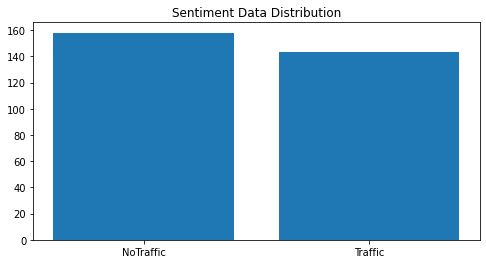

In [6]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
import random
random_idx_list = [random.randint(1,len(df.Text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,label,Text
217,NoTraffic,@MuellerSheWrote @CNN Firewalls. Block everyth...
251,Traffic,Cleared: Construction on #SANDSST WB from GOLD...
27,Traffic,Cleared: Construction on #PortJefferson Both d...
121,Traffic,Construction on #Q33Bus SB at 82 St/30 Av http...
297,Traffic,"Accident, center lane blocked in #BrooklynOnTh..."
12,Traffic,"@NYC_DOT ""Division of Traffic will conduct a s..."
225,NoTraffic,@mitchpberg @RapeMatters @wihorne @citizenstew...
246,NoTraffic,@TheShondeh @fxdvm @zei_squirrel Sitting in tr...
184,Traffic,Traffic is heavy but moving on #GrandCentralPa...
257,NoTraffic,@shanoonweeb Construction is always a pain.


## **Text Preprocessing**

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.Text.apply(lambda x: preprocess(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


## **Train-test Split**

In [11]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [12]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 240
Test Data size 61


In [13]:
train_data.head(10)


,label,Text
174,NoTraffic,@LindseyGrahamSC The tag team of Trump &amp; P...
265,Traffic,Updated: Construction on #NY27 EB from 4th Ave...
248,Traffic,Updated: Construction on #M5Bus NB at Av Of Th...
132,Traffic,The outbound #GeorgeWashingtonBridge is now a ...
235,NoTraffic,Which lead me to this next idea of brands dres...
190,NoTraffic,@nypost Delivery bicycles are a danger to NYC ...
94,Traffic,Construction on #6Line NB from Brook Av to Lon...
118,NoTraffic,Good &amp; Bad Drivers: Car Crash Compilation ...
86,Traffic,⚠️WEATHER ADVISORY⚠️\nNYC may experience sever...
288,NoTraffic,Facebook in particular has been core to Shopif...


## **Tokenization**

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.Text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 1985


In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (240, 30)
Testing X Shape: (61, 30)


In [16]:
labels = train_data.label.unique().tolist()

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (240, 1)
y_test shape: (61, 1)


## **Word Embedding**

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-03-15 17:10:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-15 17:10:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-15 17:10:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [28]:
#GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [29]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

FileNotFoundError: ignored

In [30]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [31]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## **LSTM Model Training**

In [32]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [21]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [35]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 1s 610ms/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 1s 583ms/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 1s 610ms/step - loss: 0.6931 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 1s 570ms/step - loss: 0.6930 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 1s 522ms/step - loss: 0.6930 - accuracy: 0.5292 - val_loss: 0.6931 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 1s 539ms/step - loss: 0.6930 - ac

## **Model Evaluation**

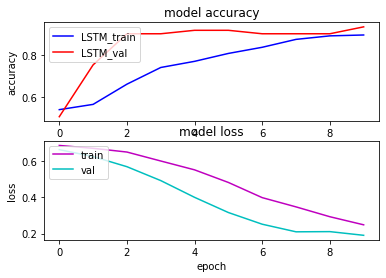

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return "Traffic" if score>0.5 else "NoTraffic"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 586ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

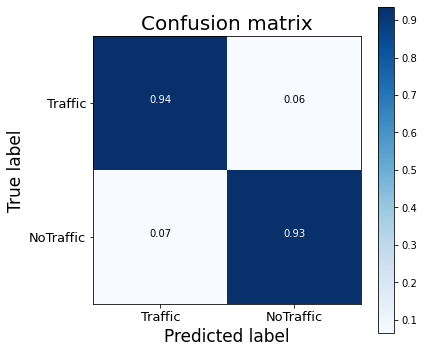

In [ ]:
cnf_matrix = confusion_matrix(test_data.label.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.label.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.label), y_pred_1d))


              precision    recall  f1-score   support

   NoTraffic       0.94      0.94      0.94        31
     Traffic       0.93      0.93      0.93        30

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61



# **BERT Model**

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [38]:
pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 3.8 MB/s 
     |████████████████████████████████| 462 kB 35.3 MB/s 


In [39]:
pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 3.7 MB/s 
     |████████████████████████████████| 352 kB 46.7 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 234 kB 33.5 MB/s 
     |████████████████████████████████| 1.1 MB 20.5 MB/s 
     |████████████████████████████████| 47.8 MB 40 kB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 


In [40]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

choose model to fine tune

In [41]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [42]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Define Model

In [43]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [51]:
classifier_model = build_classifier_model()

Model Training

In [52]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [62]:
epochs = 5

steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          optimizer_type='adamw')

AttributeError: ignored

In [63]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

ValueError: ignored

In [49]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

NameError: ignored

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')